In [1]:
import pickle
import json

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

def get_device_memory_report(device):
    print(f'Device: {device} [{torch.cuda.get_device_name(device)}]')
    free_memory, total_memory = torch.cuda.mem_get_info(device)
    
    free_memory_gb = free_memory / (1024 ** 3)
    total_memory_gb = total_memory / (1024 ** 3)
    
    print(f"Free Memory: {free_memory_gb:.2f}/{total_memory_gb:.2f} GB [{free_memory / total_memory * 100:.2f}%]")

get_device_memory_report(device)

Device: cuda:7 [NVIDIA RTX 6000 Ada Generation]
Free Memory: 47.08/47.50 GB [99.11%]


In [3]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.01):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.sinu = nn.SiLU()
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.batchnorm(x)
        x = self.sinu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.batchnorm(x)
        x = self.sinu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [4]:
from copy import deepcopy

def validate(model, val_loader, device):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for _, (data, labels) in enumerate(val_loader):
            data = data.to(device).float()
            labels = labels.to(device).long()

            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * correct / total
    return val_loss, val_accuracy

def train(model, train_loader, val_loader, num_epochs, device, lr=1e-6, _log=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []

    best_model_params = None
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        for _, (data, labels) in enumerate(train_loader):

            data = data.to(device).float()
            labels = labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_loss, val_accuracy = validate(model, val_loader, device)
        val_losses.append(val_accuracy)

        train_loss, train_accuracy = validate(model, train_loader, device)
        train_losses.append(train_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_params = model.state_dict()

        if ((epoch + 1) % 5 == 0 or epoch == 0) and _log:
            print(f'[Epoch {epoch + 1}] | Train Loss: {round(train_losses[-1], 3)} | Val Loss: {round(val_losses[-1], 3)} | Train Acc: {round(train_accuracy, 3)} | Val Acc: {round(val_accuracy, 3)}')
    
    model.load_state_dict(best_model_params)

    total_acc = 0
    train_size = 0
    for _, (data, labels) in enumerate(train_loader):
        data = data.to(device).float()
        labels = labels.to(device).long()

        outputs = model(data)
        _, predicted = outputs.max(1)
        total_acc += predicted.eq(labels).sum().item()
        train_size += labels.size(0)

    val_size = 0
    for _, (data, labels) in enumerate(val_loader):
        data = data.to(device).float()
        labels = labels.to(device).long()

        outputs = model(data)
        _, predicted = outputs.max(1)
        total_acc += predicted.eq(labels).sum().item()
        val_size += labels.size(0)
        
    total_acc /= train_size + val_size

    return total_acc


In [5]:
data_dir = '../data/blimp-output'

def load_blimp_results(model_name, grammar_type, n_shots=None, multiple_choice=True, raw_embeddings=False):

    if raw_embeddings:
        file_path = f'{data_dir}/{model_name}/{grammar_type}/no_prompt_embeddings.pkl'
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        return data

    elif multiple_choice:
        json_file_path = f'{data_dir}/{model_name}/{grammar_type}/multiple_choice_{n_shots}_shot_dataset.json'
        pkl_file_path = f'{data_dir}/{model_name}/{grammar_type}/multiple_choice_{n_shots}_shot_embeddings.pkl'
    else:
        json_file_path = f'{data_dir}/{model_name}/{grammar_type}/binary_{n_shots}_shot_dataset.json'
        pkl_file_path = f'{data_dir}/{model_name}/{grammar_type}/binary_{n_shots}_shot_embeddings.pkl'

    with open(json_file_path, 'r') as f:
        json_data = json.load(f)
    with open(pkl_file_path, 'rb') as f:
        pkl_data = pickle.load(f)
    return json_data, pkl_data

In [8]:
from random import uniform

def get_train_val_split(X, y, val_size=0.4):
    
    train_idx = np.random.choice(range(len(X)), size=int(len(X) * (1 - val_size)), replace=False)
    val_idx = np.setdiff1d(range(len(X)), train_idx)

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    return X_train, X_val, y_train, y_val

def load_raw_embeddings_dataloader(model_name, grammar_type, device, batch_size=64):

    raw_embeddings = load_blimp_results(model_name, grammar_type, raw_embeddings=True)

    X, y = [], []
    for i, example in enumerate(raw_embeddings):
        if i % 2 == 0:
            X.append(example['sentence_good'])
            y.append(1)
        else:
            X.append(example['sentence_bad'])
            y.append(0)

    X = torch.tensor(np.array(X), device=device)
    y = torch.tensor(np.array(y), device=device)

    X_train, X_val, y_train, y_val = get_train_val_split(X, y)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

def load_multiple_choice_dataloader(model_name, grammar_type, n_shots, device, batch_size=64):
    json_data, pkl_data = load_blimp_results(model_name, grammar_type, n_shots, multiple_choice=True)

    X, y = [], []
    for embedding, example in zip(pkl_data, json_data):
        X.append(embedding['embedding'])
        y.append(0 if example['answer'] == '1' else 1)

    X = torch.tensor(np.array(X), device=device)
    y = torch.tensor(np.array(y), device=device)

    X_train, X_val, y_train, y_val = get_train_val_split(X, y)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

def load_binary_dataloader(model_name, grammar_type, n_shots, device, batch_size=64):
    json_data, pkl_data = load_blimp_results(model_name, grammar_type, n_shots, multiple_choice=False)

    X, y = [], []
    for embedding, example in zip(pkl_data, json_data):
        X.append(embedding['embedding'])
        y.append(0 if example['answer'] == '0' else 1)

    X = torch.tensor(np.array(X), device=device)
    y = torch.tensor(np.array(y), device=device)

    X_train, X_val, y_train, y_val = get_train_val_split(X, y)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


In [10]:
def load_model_performance(model_name, grammar_type, n_shots, multiple_choice=True, raw_embeddings=False, num_epochs=30):
    if raw_embeddings:
        train_loader, val_loader = load_raw_embeddings_dataloader(model_name, grammar_type, device)
    elif multiple_choice:
        train_loader, val_loader = load_multiple_choice_dataloader(model_name, grammar_type, n_shots, device)
    else:
        train_loader, val_loader = load_binary_dataloader(model_name, grammar_type, n_shots, device)
    input_dim = train_loader.dataset[0][0].shape[0]
    model = MLPClassifier(input_dim, input_dim // 2, 2)
    model.to(device)

    acc = train(model, train_loader, val_loader, num_epochs=num_epochs, device=device, _log=False)
    return acc

In [11]:
import os

def load_all_blimp_performance(grammar_type, n_shots, multiple_choice=True, num_epochs=30):
    results = {}
    for folder in os.listdir(data_dir):
        if not folder.startswith('Llama'):
            continue
        for n_shot in n_shots:
            if n_shot not in results:
                results[n_shot] = {}
            acc = load_model_performance(folder, grammar_type, n_shot, multiple_choice, raw_embeddings=False, num_epochs=num_epochs)
            results[n_shot][folder] = acc
    
    return results

In [12]:
def load_raw_embeddings_performance(grammar_type, num_epochs=30):
    results = {}
    for folder in os.listdir(data_dir):
        if not folder.startswith('Llama'):
            continue
        acc = load_model_performance(folder, grammar_type, None, multiple_choice=False, raw_embeddings=True, num_epochs=num_epochs)
        results[folder] = acc
    return results

In [20]:
from matplotlib import pyplot as plt

def plot_blimp_performance(grammar_type, n_shots, num_epochs):

    multiple_choice_results = load_all_blimp_performance(grammar_type, n_shots, multiple_choice=True, num_epochs=num_epochs)
    binary_results = load_all_blimp_performance(grammar_type, n_shots, multiple_choice=False, num_epochs=num_epochs)
    raw_results = load_raw_embeddings_performance(grammar_type, num_epochs=num_epochs)

    _, axs = plt.subplots(1, 2, figsize=(9, 4))

    n_shots = list(multiple_choice_results.keys())
    datasets = [multiple_choice_results, binary_results]

    for i in range(2):
        model_data = {}
        for n_shot in datasets[i].keys():
            for model in datasets[i][n_shot].keys():
                if model not in model_data:
                    model_data[model] = []
                model_data[model].append(datasets[i][n_shot][model])
        
        colors = plt.cm.tab10.colors
        for j, model in enumerate(model_data.keys()):
            raw = raw_results[model]            
            axs[i].plot(n_shots, model_data[model], label=model, color=colors[j])
            axs[i].axhline(y=raw, linestyle='--', color=colors[j])
            for k, n_shot in enumerate(n_shots):
                axs[i].scatter(n_shot, model_data[model][k], color=colors[j], marker='o')
                axs[i].text(n_shot, model_data[model][k], f'{model_data[model][k]:.2f}', ha='center', va='bottom')
        if i == 0:
            axs[i].set_title('Multiple Choice')
        else:
            axs[i].set_title('Binary')
        axs[i].set_xlabel('N-shot')
        axs[i].set_ylabel('Accuracy')
        axs[i].legend()
    plt.tight_layout()
    plt.show()

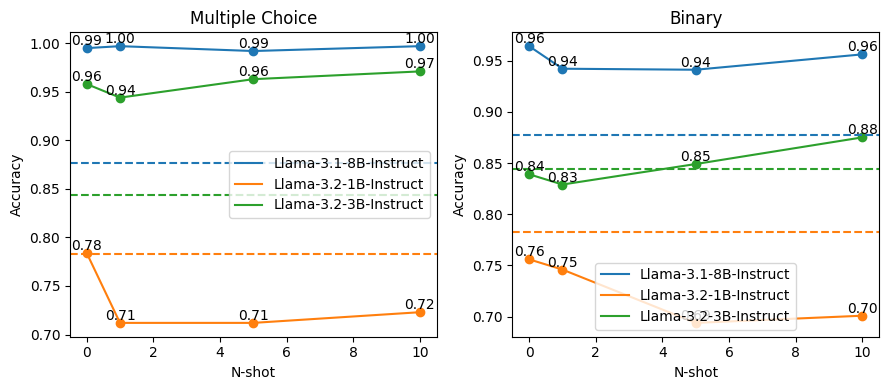

In [21]:
plot_blimp_performance('anaphor_number_agreement', [0, 1, 5, 10], 30)

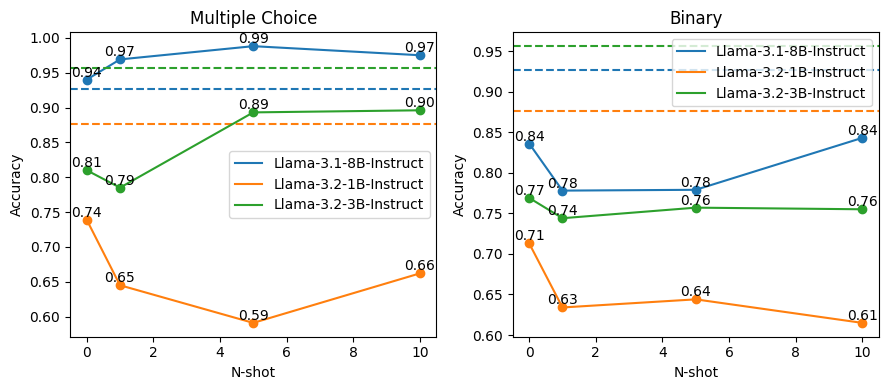

In [22]:
plot_blimp_performance('adjunct_island', [0, 1, 5, 10], 50)

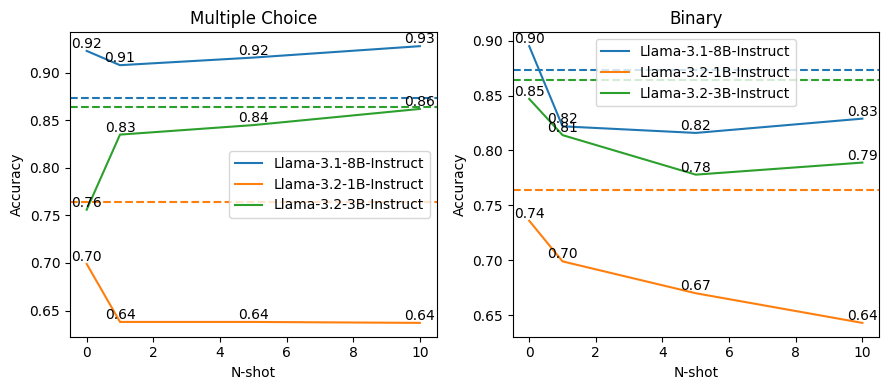

In [57]:
plot_blimp_performance('complex_NP_island', [0, 1, 5, 10], 30)

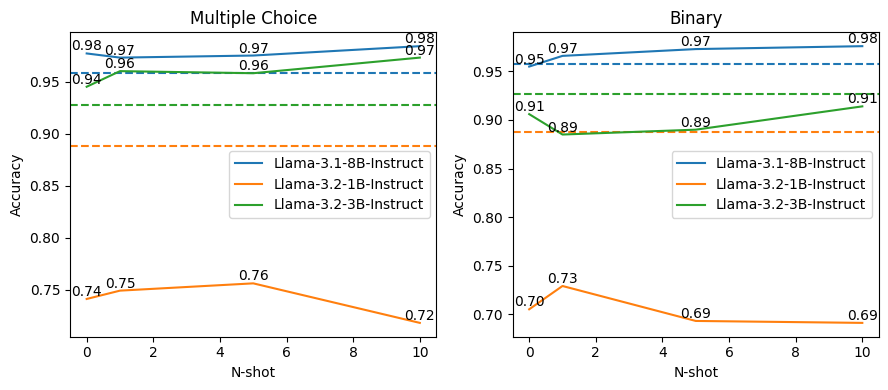

In [58]:
plot_blimp_performance('determiner_noun_agreement_1', [0, 1, 5, 10], 30)